### Import Modules

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

### Read in Data

In [25]:
dtypes = {'Date':str, 'Store Number':str, 'Store Name':str, 'City':str}
usecols = [1,2,3,5,11,19,20,21]

In [26]:
df_iowa = pd.read_csv("//datasets/Iowa_Liquor_Sales.csv", usecols = usecols, dtype=dtypes)

### Subset Data

In [27]:
df_iowa['Date'] = pd.to_datetime(df_iowa['Date'])
df_iowa['Year'] = df_iowa['Date'].dt.year

In [39]:
df_sub = df_iowa[df_iowa['Year'].isin([2017,2018,2019,2020,2021,2022])]

## Categorical Variable Feature Engineering

### Store Name Cleaning and Feature Engineering

We want to clean up the store names with the goal of being able to see which stores are part of huge chains, which ones are not, and which ones are kind of inbetween.

In [40]:
def clean_store_names(store):
    store = store.split('/')[0].split('#')[0].split('-')[0].lower().rstrip(' ')
    if (store.find('wal-mart') != -1) or (store == 'W-Mart'):
        return 'walmart'
    if store.find('target store t') != -1:
        return 'target'
    if store.find("sam's club") != -1:
        return "sam's club"
    if store.find('hy-vee') != -1:
        return 'hy-vee'
    if store.find('central city') != -1:
        return 'central city'
    return store

In [41]:
df_sub.loc[:,"Store Name"] = df_sub["Store Name"].apply(clean_store_names)

# Weird Code thing here

if there is an error for store_counts comes up saying count doesnt exist run the 1st cell that is commented out and comment out the other one. For some reason the top cell works for Jadyn and Anagah but creates an error for me. I think it is because .value_counts is returning different column names for us.

In [42]:
# store_counts = pd.DataFrame(df_sub[['Store Name', 'Store Number']].drop_duplicates()['Store Name'].value_counts()).reset_index()
# store_counts.rename(columns={"Store Name": "count", "index": "Store Name"}, inplace=True)
# store_counts.head()

In [43]:
store_counts = pd.DataFrame(df_sub[['Store Name', 'Store Number']].drop_duplicates()['Store Name'].value_counts()).reset_index()
store_counts.head()

,Store Name,count
0,casey's general store,517
1,hy,198
2,kum & go,121
3,fareway stores,108
4,walgreens,69


Here we want to create a variable to identify whether a liquor store is a major chain, a smaller chain/business or in the middle. We are doing this based on the number of distinct stores for a given store name/business name.

In [44]:
def map_store_size(dis_stores):
    if dis_stores >= 30:
        return 'major'
    else:
        if dis_stores >= 10:
            return 'middle'
        else:
            return 'minor'

In [45]:
store_counts['Store_Size'] = store_counts['count'].apply(map_store_size)

In [47]:
df_sub = df_sub.merge(store_counts, how='left', on='Store Name')

In [48]:
df_sub.head()

,Date,Store Number,Store Name,City,Category Name,State Bottle Retail,Bottles Sold,Sale (Dollars),Year,count,Store_Size
0,2018-01-23,4310,fareway stores,Cherokee,Canadian Whiskies,19.65,3.0,58.95,2018.0,108,major
1,2018-01-23,2572,hy,Cedar Falls,American Vodkas,10.38,12.0,124.56,2018.0,198,major
2,2018-01-25,2544,hy,Marshalltown,Gold Rum,6.63,12.0,79.56,2018.0,198,major
3,2018-01-25,2130,sycamore convenience,Waterloo,Flavored Rum,15.74,36.0,566.64,2018.0,1,minor
4,2018-01-22,5373,sodes green acre,Guttenberg,Whiskey Liqueur,11.24,2.0,22.48,2018.0,1,minor


#### Plot using new Store Size variable

In [49]:
df_sizes = df_sub.groupby(['Store Number','Year', 'Store_Size'])['Sale (Dollars)'].sum().reset_index()

<Axes: xlabel='Store_Size'>

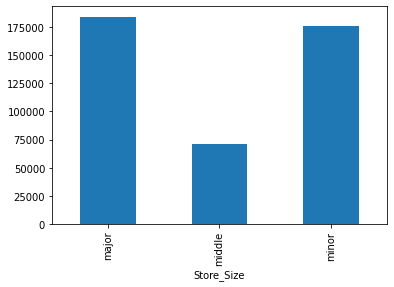

In [50]:
df_sizes.groupby(['Store_Size'])['Sale (Dollars)'].mean().plot.bar()

We see that major chains and small businesses on average purchase more alchohol than stores that are in the middle group. 

### City Population Feature Engineering

Some cities in the external dataset differed slighly compared to the Iowa alcohol dataset, so the function below fixes those cases so they match.


In [51]:
def clean_cities(city):
    city = city.lower()
    if city == 'clearlake':
        return 'clear lake'
    elif city == 'mt pleasant':
        return 'mount pleasant'
    elif city == 'lemars':
        return 'le mars'
    elif city == 'saint ansgar':
        return 'st ansgar'
    elif city == 'leclaire':
        return 'le claire'
    elif city == 'jewell':
        return 'jewell junction'
    elif city == "arnold's park":
        return 'arnolds park'
    elif city == 'grand mounds':
        return 'grand mound'
    elif city == 'lonetree':
        return 'lone tree'
    elif city == 'otumwa':
        return 'ottumwa'
    else:
        return city

In [52]:
df_sub.loc[:,'City'] = df_sub['City'].astype(str).apply(clean_cities)

This external dataset contains the populations for different cities in Iowa. We will use this to group cities into different population brackets

In [ ]:
df_cities = pd.read_csv("https://raw.githubusercontent.com/brendad8/Datasets/main/Iowa_City.csv")

In [53]:
df_cities['population'] = df_cities['population'].str.replace(",", "").astype(int)
df_cities['name'] = df_cities['name'].str.replace(" city", "").str.lower()
df_cities['name'] = df_cities['name'].str.replace(".", "")
df_cities['name'] = df_cities['name'].str.replace(" cdp", "")

In [54]:
df_sub = df_sub.merge(df_cities, left_on = 'City', right_on = 'name', how='left')

In [55]:
df_sub = df_sub[~df_sub['population'].isna()]

In [56]:
pops = df_sub[['City', 'population']].drop_duplicates()

We want to group cities into differnt population brackets. The function below maps the population of a city to a categorical variable. These brackets were arbitrarily determined.

In [58]:
def map_city_pop(pop):
    if pop >= 100000:
        return '6'
    else:
        if pop >= 50000:
            return '5'
        else:
            if pop >= 20000:
                return '4'
            else:
                if pop >= 10000:
                    return '3'
                else:
                    if pop >= 1000:
                        return '2'
                    else:
                        return '1'

In [59]:
pops.loc[:,'Pop_Bracket'] = pops['population'].apply(map_city_pop)

In [60]:
df_sub = df_sub.merge(pops, how='left', on='City')

#### Plot using new Population Bracket variable

<Axes: xlabel='Pop_Bracket'>

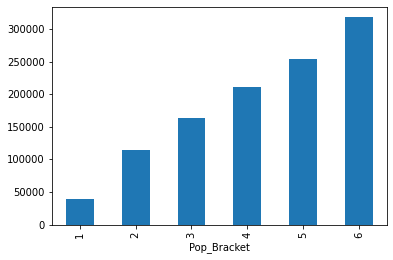

In [61]:
df_sub.groupby(['Year', 'Store Number', 'Pop_Bracket'])['Sale (Dollars)'].sum().reset_index().groupby('Pop_Bracket')['Sale (Dollars)'].mean().plot.bar()

We see that liquor stores in cities with larger populations tend to purchase more alcohol. This feels very obvious and hopefully it contributes to our model for predicting the alchohol purchased.

## Quantitative Variable Feature Engineering by Year

In this section we are going to aggregate the data for each store over an entire year with the goal of being able to use data from previous years to predict the amount of alchohol purchased by a store for the next. 

### Bottles Sold and Alcohol Purchased

In [62]:
df_bottles = df_sub.groupby(['Store Number', 'Store_Size', 'Pop_Bracket', 'Year']).sum(['Bottles Sold', 'Sale Price (Dollars)'])[['Bottles Sold', 'Sale (Dollars)']].reset_index()

In [63]:
df_bottles.rename(columns={'Sale (Dollars)':'Alc_Purchased'},inplace=True)

In [64]:
df_bottles.head()

,Store Number,Store_Size,Pop_Bracket,Year,Bottles Sold,Alc_Purchased
0,010004,minor,2,2022.0,631.0,7482.97
1,010016,middle,2,2022.0,1272.0,15788.55
2,010017,middle,2,2022.0,1288.0,15966.99
3,010018,middle,2,2022.0,1288.0,15966.99
4,010019,minor,2,2022.0,1768.0,23221.79


### Mean Price of Bottles Sold over a year

In [65]:
df_mean_prices = pd.DataFrame(df_sub.groupby(['Store Number', 'Year'])['State Bottle Retail'].mean()).reset_index().rename(columns={'State Bottle Retail':'Mean_Bottle_Price'})

In [128]:
df_mean_prices.head()

,Store Number,Year,Mean_Bottle_Price
0,010004,2022.0,17.385660
1,010016,2022.0,14.685000
2,010017,2022.0,14.549316
3,010018,2022.0,14.549316
4,010019,2022.0,26.731346


### Combine all yearly variables

In [66]:
df_comb = df_bottles.merge(df_mean_prices, on=['Store Number', 'Year'])
df_comb['Year+1'] = df_comb['Year']+1

In [67]:
df_comb.head()

,Store Number,Store_Size,Pop_Bracket,Year,Bottles Sold,Alc_Purchased,Mean_Bottle_Price,Year+1
0,010004,minor,2,2022.0,631.0,7482.97,17.385660,2023.0
1,010016,middle,2,2022.0,1272.0,15788.55,14.685000,2023.0
2,010017,middle,2,2022.0,1288.0,15966.99,14.549316,2023.0
3,010018,middle,2,2022.0,1288.0,15966.99,14.549316,2023.0
4,010019,minor,2,2022.0,1768.0,23221.79,26.731346,2023.0


## Create Response Variable to train model to predict on

We will be training our model to use data from previous years to predict the amount of alcohol a store will be purchasing in the next year

In [68]:
df_response = pd.DataFrame(df_sub.groupby(['Year', 'Store Number'])['Sale (Dollars)'].sum()).rename(columns={'Sale (Dollars)':'Res_Alc_Purchased'}).reset_index()

In [69]:
df_response.rename(columns={'Year':'Res_Year'}, inplace=True)

In [70]:
df_response['Res_Year-1'] = df_response['Res_Year'] - 1

In [71]:
df_response.head()

,Res_Year,Store Number,Res_Alc_Purchased,Res_Year-1
0,2017.0,2106,465.12,2016.0
1,2017.0,2113,1051.87,2016.0
2,2017.0,2130,1392.24,2016.0
3,2017.0,2190,752.06,2016.0
4,2017.0,2191,23148.39,2016.0


## Data using previous year's observations as predictors (n=1)

I am joining the dataset with the combined yearly variables to the dataset with the response variables. The joining condition is on store number and year_for_predictors+1 = year_for_response

In [72]:
df_model1 = df_comb.merge(df_response, left_on = ['Store Number', 'Year+1'], right_on = ['Store Number', 'Res_Year'])

In [73]:
df_model1.shape

(7779, 11)

In [74]:
df_model1.head()

,Store Number,Store_Size,Pop_Bracket,Year,Bottles Sold,Alc_Purchased,Mean_Bottle_Price,Year+1,Res_Year,Res_Alc_Purchased,Res_Year-1
0,2106,minor,4,2017.0,24.0,465.12,21.090000,2018.0,2018.0,1248878.02,2017.0
1,2106,minor,4,2018.0,86987.0,1248878.02,16.782445,2019.0,2019.0,1223186.94,2018.0
2,2106,minor,4,2019.0,85121.0,1223186.94,16.657084,2020.0,2020.0,786504.43,2019.0
3,2106,minor,4,2020.0,53237.0,786504.43,17.503160,2021.0,2021.0,1033483.12,2020.0
4,2106,minor,4,2021.0,67944.0,1033483.12,18.020315,2022.0,2022.0,615676.25,2021.0


## Data using the previous 2 year's observations as predictors (n=2)

Here is where we join 2 sequential years together for each store as predictors (df_seq) We added suffixes to differentiate variables for the different years relative to the response year. We then join on the response year so each observation contains data from 3 years. 2 sequential years as predictors and a 3rd sequential year for the response

In [75]:
df_seq = df_comb.merge(df_comb, left_on=['Store Number', 'Year+1', 'Store_Size', 'Pop_Bracket'], right_on=['Store Number', 'Year', 'Store_Size', 'Pop_Bracket'], suffixes=['_2ago', '_1ago'])

In [76]:
df_model2 = df_seq.merge(df_response, left_on = ['Store Number', 'Year+1_1ago'], right_on = ['Store Number', 'Res_Year'])

In [77]:
df_model2.shape

(5607, 16)

In [78]:
df_model2.head()

,Store Number,Store_Size,Pop_Bracket,Year_2ago,Bottles Sold_2ago,Alc_Purchased_2ago,Mean_Bottle_Price_2ago,Year+1_2ago,Year_1ago,Bottles Sold_1ago,Alc_Purchased_1ago,Mean_Bottle_Price_1ago,Year+1_1ago,Res_Year,Res_Alc_Purchased,Res_Year-1
0,2106,minor,4,2017.0,24.0,465.12,21.090000,2018.0,2018.0,86987.0,1248878.02,16.782445,2019.0,2019.0,1223186.94,2018.0
1,2106,minor,4,2018.0,86987.0,1248878.02,16.782445,2019.0,2019.0,85121.0,1223186.94,16.657084,2020.0,2020.0,786504.43,2019.0
2,2106,minor,4,2019.0,85121.0,1223186.94,16.657084,2020.0,2020.0,53237.0,786504.43,17.503160,2021.0,2021.0,1033483.12,2020.0
3,2106,minor,4,2020.0,53237.0,786504.43,17.503160,2021.0,2021.0,67944.0,1033483.12,18.020315,2022.0,2022.0,615676.25,2021.0
4,2113,minor,1,2017.0,67.0,1051.87,18.482105,2018.0,2018.0,5273.0,75058.27,16.548311,2019.0,2019.0,78947.79,2018.0


## Data using the previous 3 year's observations as predictors (n=3)

Here we are doing the same thing as we did above but just using three years as predictors. Here we join an additional 3rd year of data to the data including 2 sequential years for a store. The suffixes are now relative to the 3rd year and the response year is one year ahead of the 3rd year. We then join the response on 3rd_year+1 = response_year

In [79]:
df_seq2 = df_seq.merge(df_comb, left_on=['Store Number', 'Store_Size', 'Pop_Bracket', 'Year+1_1ago'], right_on=['Store Number', 'Store_Size', 'Pop_Bracket', 'Year'])

In [80]:
df_model3 = df_seq2.merge(df_response, left_on = ['Store Number', 'Year'], right_on = ['Store Number', 'Res_Year-1'])

In [81]:
df_model3.shape

(3719, 21)

In [82]:
df_model3.columns

Index(['Store Number', 'Store_Size', 'Pop_Bracket', 'Year_2ago',
       'Bottles Sold_2ago', 'Alc_Purchased_2ago', 'Mean_Bottle_Price_2ago',
       'Year+1_2ago', 'Year_1ago', 'Bottles Sold_1ago', 'Alc_Purchased_1ago',
       'Mean_Bottle_Price_1ago', 'Year+1_1ago', 'Year', 'Bottles Sold',
       'Alc_Purchased', 'Mean_Bottle_Price', 'Year+1', 'Res_Year',
       'Res_Alc_Purchased', 'Res_Year-1'],
      dtype='object')

In [83]:
df_model3.head()

,Store Number,Store_Size,Pop_Bracket,Year_2ago,Bottles Sold_2ago,Alc_Purchased_2ago,Mean_Bottle_Price_2ago,Year+1_2ago,Year_1ago,Bottles Sold_1ago,...,Mean_Bottle_Price_1ago,Year+1_1ago,Year,Bottles Sold,Alc_Purchased,Mean_Bottle_Price,Year+1,Res_Year,Res_Alc_Purchased,Res_Year-1
0,2106,minor,4,2017.0,24.0,465.12,21.090000,2018.0,2018.0,86987.0,...,16.782445,2019.0,2019.0,85121.0,1223186.94,16.657084,2020.0,2020.0,786504.43,2019.0
1,2106,minor,4,2018.0,86987.0,1248878.02,16.782445,2019.0,2019.0,85121.0,...,16.657084,2020.0,2020.0,53237.0,786504.43,17.503160,2021.0,2021.0,1033483.12,2020.0
2,2106,minor,4,2019.0,85121.0,1223186.94,16.657084,2020.0,2020.0,53237.0,...,17.503160,2021.0,2021.0,67944.0,1033483.12,18.020315,2022.0,2022.0,615676.25,2021.0
3,2113,minor,1,2017.0,67.0,1051.87,18.482105,2018.0,2018.0,5273.0,...,16.548311,2019.0,2019.0,6052.0,78947.79,16.283819,2020.0,2020.0,7437.09,2019.0
4,2130,minor,5,2017.0,96.0,1392.24,14.502500,2018.0,2018.0,69700.0,...,17.231580,2019.0,2019.0,74268.0,1173271.75,17.425406,2020.0,2020.0,951198.97,2019.0


## Custom Multiple Regression Functions

In [84]:
def multiple_regression_ridge(X, Y, lam, intercept=True):
    if intercept:
        X = pd.concat([pd.Series([1]*X.shape[0]), X], axis=1).to_numpy()
    else:
        X = X.to_numpy()
    Y = Y.to_numpy()
    return np.linalg.inv((X.T @ X) + lam*np.identity(X.shape[1])) @ X.T @ Y

def try_many_lambdas(X, Y, lams, intercept):
    lams = np.array(lams)
    return [multiple_regression_ridge(X, Y, lam, intercept) for lam in lams]

def tune_lambda_split(train_x, train_y, test_x, test_y, lams, intercept, metric):
    
    df_res = pd.DataFrame()
    df_res['lambda'] = lams
    vals = [0]*len(lams)
    est = try_many_lambdas(train_x, train_y, lams, intercept)
    
    for i in range(len(est)):
        
        if intercept:
            y_hat = pd.Series(pd.concat([pd.Series([1]*test_x.shape[0]), test_x], axis=1).to_numpy() @ est[i])
        else:
            y_hat = pd.Series(test_x.to_numpy() @ est[i])
        
        if metric == 'R_sq':
            y_bar = test_y.mean()
            vals[i] = 1-((((test_y-y_hat)**2).mean())/(((test_y-y_bar)**2).mean()))
            
        elif metric == 'MSE':
            vals[i] = (np.square(test_y-y_hat)).mean()
            
        elif metric == 'MAE':
            vals[i] = (np.abs(test_y-y_hat)).mean()
            
        else:
            print('Please use valid metric :)')

    df_res[metric] = vals
    return df_res

def tune_lambda_cv(X, Y, lams, intercept, metric, splits):
    df_res = pd.DataFrame(columns=['lambda', metric])
    kf = KFold(n_splits=splits, shuffle=True)
    splits = kf.split(X)
    for train, test in splits:
        
        train_x = X.iloc[train].reset_index(drop=True)
        train_y = Y.iloc[train].reset_index(drop=True)
        
        test_x = X.iloc[test].reset_index(drop=True)
        test_y = Y.iloc[test].reset_index(drop=True)

        df_res = pd.concat([df_res, tune_lambda_split(train_x, train_y, test_x, test_y, lams, intercept, metric)])
    return df_res.groupby('lambda')[metric].mean()

## Model Tuning for determining n

### n = number of previous years to use for predicting alc purchased for next

We told the client we would test using data from previous years to predict the results for the following year. We decided to try using the previous year, 2 years, and 3 years. Here we test comprable models for each set of data to determine which data to use for an optimal model

In [85]:
# Create Dummy Variables For Potential Categorical Variables in Model
ct = make_column_transformer(
(OneHotEncoder(), ['Store_Size', 'Pop_Bracket']), remainder='passthrough')

## n=1

In [86]:
model1_vars = ['Store_Size', 'Pop_Bracket', 'Bottles Sold', 'Alc_Purchased', 'Mean_Bottle_Price']

In [87]:
X=df_model1[model1_vars]
Y=df_model1['Res_Alc_Purchased']

In [88]:
X = pd.DataFrame(ct.fit_transform(X)).drop(columns=[0,3])

In [89]:
tune_lambda_cv(X, Y, [0], True, 'R_sq', 5)

lambda
0    0.720697
Name: R_sq, dtype: float64

## n=2

In [90]:
model2_vars = ['Store_Size', 'Pop_Bracket', 'Bottles Sold_2ago', 'Alc_Purchased_2ago', 'Mean_Bottle_Price_2ago', 'Bottles Sold_1ago', 'Alc_Purchased_1ago', 'Mean_Bottle_Price_1ago']

In [91]:
X=df_model2[model2_vars]
Y=df_model2['Res_Alc_Purchased']

In [92]:
X = pd.DataFrame(ct.fit_transform(X)).drop(columns=[0,3])

In [93]:
tune_lambda_cv(X, Y, [0], True, 'R_sq', 5)

lambda
0    0.885671
Name: R_sq, dtype: float64

## n=3

In [94]:
model3_vars = ['Store_Size', 'Pop_Bracket', 'Bottles Sold_2ago', 'Alc_Purchased_2ago', 'Mean_Bottle_Price_2ago', 'Bottles Sold_1ago', 'Alc_Purchased_1ago', 'Mean_Bottle_Price_1ago', 'Bottles Sold', 'Alc_Purchased', 'Mean_Bottle_Price']

In [95]:
X=df_model3[model3_vars]
Y=df_model3['Res_Alc_Purchased']

In [96]:
X = pd.DataFrame(ct.fit_transform(X)).drop(columns=[0,3])

In [97]:
tune_lambda_cv(X, Y, [0], True, 'R_sq', 5)

lambda
0    0.883537
Name: R_sq, dtype: float64

### Results

Using the same set of variables within each year, the models using data from the previous 2 or 3 years provided the best models. Since using an additonal 3rd year of data did not increase the effectiveness of the model significantly, we will proceed with tuning the model which used data from the previous 2 years to make our model as simple as possible. 

## Model Tuning

We will be tuning the model which uses the previous 2 years since it is more simple than using 3 years and produced results that were just as good. Next we will determine which set of variables to use.

### Variable Tuning

These are the different combinations of variables we will try training the model on

In [98]:
var_set1 = ['Alc_Purchased_2ago', 'Alc_Purchased_1ago']
var_set2 = ['Store_Size', 'Alc_Purchased_2ago', 'Alc_Purchased_1ago']
var_set3 = ['Pop_Bracket', 'Alc_Purchased_2ago', 'Alc_Purchased_1ago']
var_set4 = ['Store_Size', 'Pop_Bracket', 'Alc_Purchased_2ago', 'Alc_Purchased_1ago']
var_set5 = ['Store_Size', 'Pop_Bracket', 'Bottles Sold_2ago', 'Alc_Purchased_2ago', 'Mean_Bottle_Price_2ago', 'Bottles Sold_1ago', 'Alc_Purchased_1ago', 'Mean_Bottle_Price_1ago']

#### Set 1

In [99]:
X=df_model2[var_set1]
Y=df_model2['Res_Alc_Purchased']

In [100]:
tune_lambda_cv(X, Y, [0], True, 'R_sq', 5)

lambda
0    0.88644
Name: R_sq, dtype: float64

In [101]:
multiple_regression_ridge(X,Y,0,True)

array([ 4.16443964e+03, -4.87918599e-02,  9.53809312e-01])

#### Set 2

In [102]:
X=df_model2[var_set2]
Y=df_model2['Res_Alc_Purchased']

In [103]:
ct = make_column_transformer(
(OneHotEncoder(), ['Store_Size']), remainder='passthrough')

In [104]:
X = pd.DataFrame(ct.fit_transform(X)).drop(columns=[0],axis=1)

In [105]:
tune_lambda_cv(X, Y, [0], True, 'R_sq', 5)

lambda
0    0.894568
Name: R_sq, dtype: float64

In [106]:
multiple_regression_ridge(X,Y,0,True)

array([ 4.66691453e+03, -6.97697976e+03, -1.47021045e+00, -4.87786449e-02,
        9.53602200e-01])

#### Set 3

In [107]:
X=df_model2[var_set3]
Y=df_model2['Res_Alc_Purchased']

In [108]:
ct = make_column_transformer(
(OneHotEncoder(), ['Pop_Bracket']), remainder='passthrough')

In [109]:
X = pd.DataFrame(ct.fit_transform(X)).drop(columns=[0])

In [110]:
tune_lambda_cv(X, Y, [0], True, 'R_sq', 5)

lambda
0    0.887233
Name: R_sq, dtype: float64

In [111]:
multiple_regression_ridge(X,Y,0,True)

array([ 9.69596208e+02,  1.64832536e+03,  4.82746613e+03, -1.60549171e+03,
        6.40686060e+03,  1.20512960e+04, -4.88400016e-02,  9.52758932e-01])

#### Set 4

In [112]:
X=df_model2[var_set4]
Y=df_model2['Res_Alc_Purchased']

In [113]:
ct = make_column_transformer(
(OneHotEncoder(), ['Store_Size', 'Pop_Bracket']), remainder='passthrough')

In [114]:
X = pd.DataFrame(ct.fit_transform(X)).drop(columns=[0,3], axis=1)

In [115]:
tune_lambda_cv(X, Y, [0], True, 'R_sq', 5)

lambda
0    0.89193
Name: R_sq, dtype: float64

In [116]:
multiple_regression_ridge(X,Y,0,True)

array([ 1.23843141e+03, -1.00642797e+04, -2.24857961e+02,  1.81975896e+03,
        5.08916031e+03, -7.32963009e+02,  7.34188813e+03,  1.36620615e+04,
       -4.88406236e-02,  9.52297715e-01])

#### Set 5

In [117]:
X=df_model2[var_set5]
Y=df_model2['Res_Alc_Purchased']

In [118]:
ct = make_column_transformer(
(OneHotEncoder(), ['Store_Size', 'Pop_Bracket']), remainder='passthrough')

In [119]:
X = pd.DataFrame(ct.fit_transform(X)).drop(columns=[0,3], axis=1)

In [120]:
tune_lambda_cv(X, Y, [0], True, 'R_sq', 5)

lambda
0    0.898649
Name: R_sq, dtype: float64

In [121]:
multiple_regression_ridge(X,Y,0,True)

array([-2.44143179e+03, -1.06833735e+04, -2.92031509e+03,  5.98507383e+02,
        1.29559971e+03, -4.94881289e+03,  2.55668456e+03,  5.80882372e+03,
       -7.10548853e+00,  3.89992352e-01, -3.65106908e+02,  6.31279585e+00,
        5.69550322e-01,  6.21990158e+02])

### Results

We will pick variable set one since it is the simplest model and does just as good of a job at predicting next years alc purchased amount as the other models with more variables. 

## Lambda Tuning

Here is where we will determine an optimal lambda to use for the model or whether to use one at all. 

In [122]:
var_set1 = ['Alc_Purchased_2ago', 'Alc_Purchased_1ago']

X=df_model2[var_set1]
Y=df_model2['Res_Alc_Purchased']

In [123]:
scaler = StandardScaler()
scaler.fit(X)

StandardScaler()

In [124]:
X = pd.DataFrame(scaler.transform(X))
X.head()

,0,1
0,-0.367026,1.695072
1,2.145687,1.651560
2,2.093978,0.911973
3,1.215056,1.330268
4,-0.365845,-0.292968


In [125]:
tune_lambda_cv(X, Y, [0, .1, 10, 100, 1000], True, 'R_sq', 5)

lambda
0.0       0.876478
0.1       0.876480
10.0      0.876722
100.0     0.877131
1000.0    0.841536
Name: R_sq, dtype: float64

In [126]:
tune_lambda_cv(X, Y, [0, .1, 10, 100, 1000], True, 'MSE', 5)

lambda
0.0       4.073460e+10
0.1       4.073318e+10
10.0      4.060221e+10
100.0     4.010520e+10
1000.0    5.036903e+10
Name: MSE, dtype: float64

In [127]:
tune_lambda_cv(X, Y, [0, .1, 10, 100, 1000], True, 'MAE', 5)

lambda
0.0       61179.027016
0.1       61181.140903
10.0      61391.285501
100.0     63338.059009
1000.0    79222.810296
Name: MAE, dtype: float64

### Results

We will use lambda=0 which is just ordinary least squares regression for our final model since it produces the highest R_sq, lowest MSE, and lowest MAE for many different runs of tune_lambda_cv

# Summary of Final Model Decisions

In this codebook we uncovered that:

1. We will train our model using the previous 2 years of data to predict the response for the next year
2. Using just the alcohol purchased by a store for the 2 previous years as predictors was sufficient for predicting the alchohol purchased for the next year
3. We decided to use Ordinary least squares regression over ridge regression since it produced the best results for predicing observations the model was not trained on